In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import sys
sys.path.append('../')

from utils.processing import *
from utils.visualisation import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold, GridSearchCV, train_test_split, validation_curve
from sklearn.compose import TransformedTargetRegressor, make_column_transformer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder, MinMaxScaler, FunctionTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.decomposition import PCA, TruncatedSVD, SparsePCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.cluster import DBSCAN

np.random.seed(0)

In [3]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_colwidth', 80)

In [4]:
# load data set
df = pd.read_csv('../data/train.csv')
df_train_orig = df.copy()

In [5]:
# Utility functions
def prepare_data_for_regression(df, drop_columns=[]):
    adfs = read_aux_csv('../data')
    df = join_aux(df, adfs)
    df = df.drop(columns=drop_columns)

    return df

def rmse(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    score = np.sqrt(mse)
    return score

def rmse_scorer():
    return make_scorer(rmse, greater_is_better=False)

def split_data(df):
    X = df.drop('price', axis=1)
    y = df['price']
    
    return X, y

# Constants
initial_drop_columns = [
    'address',
    'title',
    'listing_id',
    'property_name',
    'available_unit_types',
    'property_details_url',
    'elevation',
    'tenure',
    'property_type',
    'floor_level',
    'furnishing',
]

drop_columns = initial_drop_columns + [
    'area_size',
    'population',
    'subzone',
    'lat',
    'lng',
    'floor_level_ground',
    'floor_level_high',
    'floor_level_low',
    'floor_level_mid',
    'floor_level_penthouse',
    'floor_level_top',
    'furnishing_partial',
    'furnishing_unfurnished',
    'furnishing_unspecified',
    'line_cc',
    'line_ce',
    'line_cg',
    'line_dt',
    'line_ew',
    'line_ne',
    'line_ns',
    'line_te',
    'gep_pri_sch_within_1km',
    'gep_pri_sch_within_1km_2km',
    'cc_type_CR',
    'cc_type_IEBP',
    'cc_type_IHL',
]

In [6]:
# Prepare training data set
df_train = preprocess(df_train_orig.copy())
df_train = prepare_data_for_regression(df_train, drop_columns=drop_columns)
df_train

,built_year,num_beds,num_baths,size_sqft,total_num_units,subzone,planning_area,price,property_type_private,property_type_public,tenure_high_year,tenure_low_year,nearest_mrt_distance_in_km,nearest_pri_sch_distance_in_km,nearest_gep_pri_sch_distance_in_km,gep_pri_sch_outside_2km,pri_sch_within_500m,pri_sch_outside_500m,nearest_com_centre_distance_in_km,cc_type_BN,nearest_mall_distance_in_km,area_size,population,density,region
0,1988.0,3.0,2.0,1115.0,116.0,yishun south,yishun,514500.0,0,1,0,0,0.574204,0.275582,6.194099,1,1,0,3.338999,0,0.621334,1.3402,42240,31517.683928,n
1,1992.0,4.0,2.0,1575.0,NaN,serangoon north,serangoon,995400.0,0,1,0,1,1.734303,0.122925,0.122925,0,1,0,2.401882,1,0.552544,0.6847,15940,23280.268731,ne
2,2022.0,4.0,6.0,3070.0,56.0,mountbatten,marine parade,8485000.0,1,0,1,0,1.319766,0.891475,1.872702,0,0,1,2.171328,1,0.824208,1.7119,9980,5829.779777,c
3,2023.0,3.0,2.0,958.0,638.0,farrer court,bukit timah,2626000.0,1,0,1,0,0.726006,1.090371,1.090371,0,0,1,1.605928,1,0.907063,0.5588,6180,11059.413028,c
4,2026.0,2.0,1.0,732.0,351.0,anson,downtown core,1764000.0,1,0,0,1,0.371115,0.464835,2.742534,1,1,0,1.869574,0,0.430415,0.1032,80,775.193798,c
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20140,2026.0,2.0,2.0,635.0,605.0,tagore,ang mo kio,1050000.0,1,0,0,1,0.149941,0.790370,4.691173,1,0,1,3.163579,0,2.014133,3.3342,7950,2384.380061,ne
20141,2026.0,2.0,2.0,883.0,137.0,lavender,kallang,2087400.0,1,0,1,0,0.443603,0.660929,2.178475,1,0,1,1.641446,1,0.535185,0.7569,9690,12802.219580,c
20142,2023.0,4.0,4.0,1378.0,340.0,moulmein,novena,4193700.0,1,0,1,0,0.424244,0.367552,0.367552,0,1,0,0.856170,1,0.764410,1.3475,9300,6901.669759,c
20143,2017.0,3.0,2.0,1205.0,402.0,woodlands east,woodlands,754800.0,0,1,0,1,0.631718,0.230075,10.658711,1,1,0,2.165768,0,0.601720,2.5535,98980,38762.482867,n


In [7]:
X_train, y_train = split_data(df_train)

In [8]:
ct = make_column_transformer(
    (OneHotEncoder(sparse=False, handle_unknown='ignore'), ["region", "planning_area"]),
    remainder='passthrough')

def ttr(pipeline):
    return TransformedTargetRegressor(regressor=pipeline, transformer=StandardScaler())

def transform_data(df):
    p = make_pipeline(ct, StandardScaler(), KNNImputer())
    p.fit(df)
    
    return pd.DataFrame(data=p.transform(df), columns=p.get_feature_names_out())

In [9]:
t_X_train = transform_data(X_train)
t_X_train[t_X_train.isna().any(axis=1)]

,pipeline__num_beds,pipeline__num_baths,pipeline__built_year,pipeline__total_num_units,standardscaler__size_sqft,standardscaler__nearest_mrt_distance_in_km,standardscaler__nearest_pri_sch_distance_in_km,standardscaler__nearest_gep_pri_sch_distance_in_km,standardscaler__nearest_com_centre_distance_in_km,standardscaler__nearest_mall_distance_in_km,standardscaler__area_size,standardscaler__population,standardscaler__density,onehotencoder__region_c,onehotencoder__region_e,onehotencoder__region_n,onehotencoder__region_ne,onehotencoder__region_w,onehotencoder__subzone_admiralty,onehotencoder__subzone_alexandra hill,onehotencoder__subzone_alexandra north,onehotencoder__subzone_aljunied,onehotencoder__subzone_anak bukit,onehotencoder__subzone_anchorvale,onehotencoder__subzone_ang mo kio town centre,...,onehotencoder__planning_area_paya lebar,onehotencoder__planning_area_punggol,onehotencoder__planning_area_queenstown,onehotencoder__planning_area_river valley,onehotencoder__planning_area_rochor,onehotencoder__planning_area_seletar,onehotencoder__planning_area_sembawang,onehotencoder__planning_area_sengkang,onehotencoder__planning_area_serangoon,onehotencoder__planning_area_singapore river,onehotencoder__planning_area_southern islands,onehotencoder__planning_area_tampines,onehotencoder__planning_area_tanglin,onehotencoder__planning_area_tengah,onehotencoder__planning_area_toa payoh,onehotencoder__planning_area_woodlands,onehotencoder__planning_area_yishun,remainder__property_type_private,remainder__property_type_public,remainder__tenure_high_year,remainder__tenure_low_year,remainder__gep_pri_sch_outside_2km,remainder__pri_sch_within_500m,remainder__pri_sch_outside_500m,remainder__cc_type_BN


In [10]:
def run_models(models, X, y):    
    model_scores = dict()
    
    for k, model in models.items():
        
        regr = ttr(make_pipeline(ct, StandardScaler(), KNNImputer(), *model))
        
        regr.fit(X, y)
        scores = cross_validate(regr, X, y, cv=5, scoring=rmse_scorer())
        model_scores[k] = [regr, scores]
        print(k, scores['test_score'].mean())
        
    return model_scores

In [11]:
%%time 

models = {
    "Default": [xgb.XGBRegressor(n_jobs=-2)],
    "Grid": [xgb.XGBRegressor(learning_rate=0.08, max_depth=5, n_jobs=-2)],
    "Manual": [xgb.XGBRegressor(learning_rate=0.05, max_depth=5, n_jobs=-2)],
    "PCA-Grid": [PCA(n_components=23), xgb.XGBRegressor(learning_rate=0.08, max_depth=8, n_jobs=-2)],
    "PCA-Manual": [PCA(n_components=23), xgb.XGBRegressor(learning_rate=0.05, max_depth=5, n_jobs=-2)],
}

model_scores = run_models(models, X_train, y_train)

Default -1889353.2991605562
Grid -1907321.9538856
Manual -1933061.6713464807
PCA-Grid -1921915.851046215
PCA-Manual -2103867.0757625294
CPU times: user 14min 12s, sys: 5min 5s, total: 19min 17s
Wall time: 1min 45s


<AxesSubplot: >

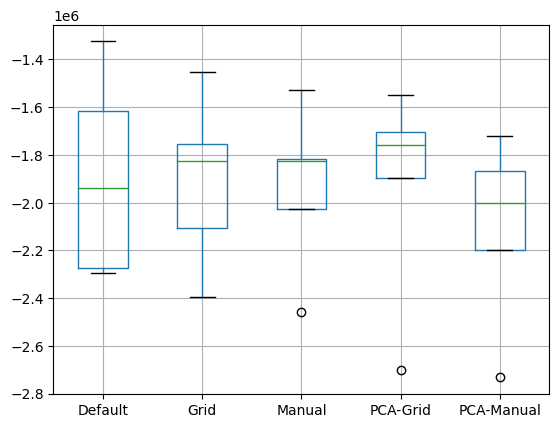

In [12]:
data = dict(map(lambda x: [x[0], x[1][1]['test_score']], model_scores.items()))
pd.DataFrame(data).boxplot()

In [13]:
df_test = preprocess(pd.read_csv('../data/test.csv'), is_target=True)
X_test = prepare_data_for_regression(df_test, drop_columns=drop_columns)

for k, v in model_scores.items():
    regr, scores = v
    y_predict = regr.predict(X_test)
    print(k, rmse(y_train, regr.predict(X_train)))
    X_test['Predicted'] = y_predict
    
    print(y_predict[0:10])

    submission = X_test[['Predicted']]
    filename = "submision-%s.csv" % (k)
    submission.to_csv(filename, index=True, index_label='id', header=True, columns=['Predicted'])

Default 542950.1262073584
[1152424.5  1343267.2  1127560.4   755921.    782892.    696223.75
 3932649.2  1049734.9   411027.53 1399066.  ]
Grid 1161664.6236960953
[1160916.9  1543696.8  1387726.    758108.5   791625.25  690334.25
 5844568.5  1030950.1   425758.28 1725712.8 ]
Manual 1284760.5869202109
[1262973.8  1553740.5  1412925.1   808385.75  857540.75  740061.5
 5930099.   1039603.5   490354.78 1708262.5 ]
PCA-Grid 521406.7079726088
[1169913.2  1609420.5  1237732.2   716805.25  636458.    685041.75
 7381684.5   796613.25  383439.78 1595952.4 ]
PCA-Manual 1324393.3528990967
[1059814.2  1749991.2  1078679.9   830133.75  640604.    783799.75
 6346886.    915650.75  517098.78 1825811.1 ]
